In [2]:
import os
os.chdir("/root/notebooks/spo")

In [3]:
import os, argparse, yaml
from pathlib import Path
import torch
from accelerate import Accelerator
from itertools import product

from src.utils.io_helpers import ensure_dir, append_csv
from src.utils.calibration import calibrate_beta_for_kappa
from src.utils.metrics import expected_true_reward, kl_to_uniform
from src.models.mlp_policy import MLPPolicy
from src.trainers.sft_trainer import SFTTrainer
from src.trainers.dpo_trainer import DPOTrainer
from src.trainers.pspo_trainer import PSPOTrainer
from src.trainers.espo_trainer import ESPOTrainer
from src.trainers.smsspo_trainer import SMSSPOTrainer
from src.data.simulate_pairs import generate_dataset
from src.data.utils import set_seed


In [4]:
set_seed(1)

In [7]:
data = generate_dataset(
    n_pairs=200000,
    n_val_calib=10000,
    n_test=50000,
    n_actions=10,
    feat_dim=10,
    link='beta_sigmoid',
    beta_a=2.0,
    beta_b=5.0,
    seed=1
)
x, y0, y1, z, W = data['train']
x_calib = data['calib_x']
x_test = data['test_x']


In [9]:
from src.data.simulate_pairs import true_reward
r0 = true_reward(x, y0, W)
r1 = true_reward(x, y1, W)
delta = r1 - r0

In [12]:
%pylab

Using matplotlib backend: inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(array([5.2000e+01, 1.0570e+03, 1.0476e+04, 4.9235e+04, 8.4550e+04,
        4.4743e+04, 8.9830e+03, 8.6200e+02, 4.1000e+01, 1.0000e+00]),
 array([-6.5601244 , -5.08938503, -3.61864567, -2.1479063 , -0.67716694,
         0.79357243,  2.26431179,  3.73505116,  5.20579052,  6.67652988,
         8.14726925]),
 <BarContainer object of 10 artists>)

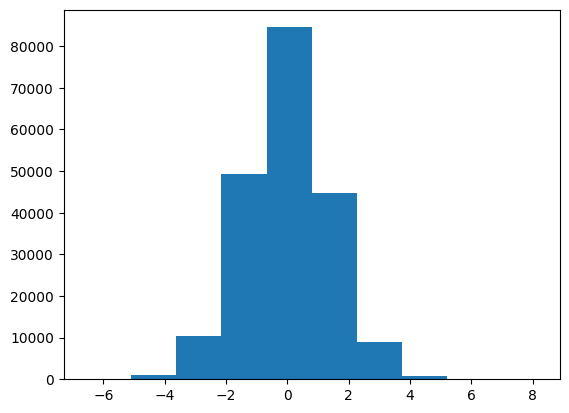

In [18]:
hist(delta.detach().cpu().numpy())